In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

def pol2cart(r, tet, phi):
    x = r*np.sin(tet)*np.cos(phi)
    y = r*np.sin(tet)*np.sin(phi)
    z = r*np.cos(tet)
    return x,y,z

def cart2pol(vec):
    x = vec[0]
    y = vec[1]
    z = vec[2]
    r = np.linalg.norm(vec)
    tet = np.arccos(z/r)
    phi = np.arctan(y/x)
    return r, tet, phi

def r_ort(tet, phi):
    x = np.sin(tet)*np.cos(phi)
    y = np.sin(tet)*np.sin(phi)
    z = np.cos(tet)
    return np.array([x, y, z])

def tet_ort(tet, phi):
    x = np.cos(tet)*np.cos(phi)
    y = np.cos(tet)*np.sin(phi)
    z = -np.sin(tet)
    return np.array([x, y, z])

def phi_ort(tet, phi):
    x = -np.sin(phi)
    y = np.cos(phi)
    z = 0
    return np.array([x, y, z])


In [2]:
import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector

class Material:
    def __init__(self, Ms, gamma=5e8, alpha=0.018, Hkeff=6100.0):
        self.Ms = Ms
        self.gamma = gamma
        self.alpha = alpha
        self.Hkeff = Hkeff


def StonerWohlfarth_Heff(M, Hkeff):
    Mx, My, Mz = M
    x = -0.5*Hkeff*Mx*Mz**2/(Mx**2 + My**2 + Mz**2)**(3/2)
    y = -0.5*Hkeff*My*Mz**2/(Mx**2 + My**2 + Mz**2)**(3/2)
    z = Hkeff*Mz*(1.0*Mx**2 + 1.0*My**2 + 0.5*Mz**2)/(Mx**2 + My**2 + Mz**2)**(3/2)
    
    return np.array([x, y, z])


def DemagnetizationHeff(M):
    return np.array([0., 0., -4.*np.pi*M[2]])

class StoenerWolfarth:
    def __init__(self):
        S = CoordSys3D('S')
        
        Ku = symbols("Ku")
        Mx, My, Mz = symbols('Mx My Mz')
        M = Mx*S.i + My*S.j + Mz*S.k
        
        sin_tet_sqr = (Mx**2 + My**2)/(Mx**2 + My**2 + Mz**2)
        
        E = Ku*sin_tet_sqr
        
        Hx = -sym.diff(E, Mx)
        Hy = -sym.diff(E, My)
        Hz = -sym.diff(E, Mz)
        
        lambda_var_set = (Ku, Mx, My, Mz)
        self.Heff_x = lambdify(lambda_var_set, Hx, 'numpy')
        self.Heff_y = lambdify(lambda_var_set, Hy, 'numpy')
        self.Heff_z = lambdify(lambda_var_set, Hz, 'numpy')
    
    def Heff(self, M, Ku):
        return np.array([
            self.Heff_x(Ku, M[0], M[1], M[2]),
            self.Heff_y(Ku, M[0], M[1], M[2]),
            self.Heff_z(Ku, M[0], M[1], M[2])
        ])
    


In [3]:
import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector

class LLG_EQ:
    def __init__(self):
        S = CoordSys3D('S')
        
        x, y, z = symbols('x y z')
        dMdt = x*S.i + y*S.j + z*S.k
        
        Mx, My, Mz = symbols('Mx My Mz')
        M = Mx*S.i + My*S.j + Mz*S.k
        
        Hx, Hy, Hz = symbols('Hx Hy Hz')
        H = Hx*S.i + Hy*S.j + Hz*S.k
        
        g = sym.Symbol('g')
        a = sym.Symbol('a')
        Ms = sym.Symbol('Ms')
        
        vec_eq = -dMdt - g*M.cross(H)+(a/Ms)*(M.cross(dMdt))
        sol = sym.solve(vec_eq.to_matrix(S), dMdt.to_matrix(S))
        
        sol[x] = simplify(sol[x])
        sol[y] = simplify(sol[y])
        sol[z] = simplify(sol[z])
        
        self.sol_lamb = dict()
        lambda_var_set = (
            a, g, Ms, 
            Mx, My, Mz, 
            Hx, Hy, Hz)
        
        self.sol_lamb['x'] = lambdify(lambda_var_set, sol[x], 'numpy')
        self.sol_lamb['y'] = lambdify(lambda_var_set, sol[y], 'numpy')
        self.sol_lamb['z'] = lambdify(lambda_var_set, sol[z], 'numpy')
        
        symbs = [x, y, z]
        dsymbs = [Mx, My, Mz]
        self.jac_mat = []
        for i in range(3):
            jac_row = []
            for j in range(3):
                jac_row.append(
                    lambdify(
                        lambda_var_set, 
                        simplify(sol[symbs[i]].diff(dsymbs[j]))
                    )
                )
            self.jac_mat.append(jac_row)
    
    def right_hand(self, Heff, M, film):
        x = self.sol_lamb['x'](
            film.alpha, film.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        y = self.sol_lamb['y'](
            film.alpha, film.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        z = self.sol_lamb['z'](
            film.alpha, film.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        return [x, y, z]
    
    def jacobian(self, M, Heff, film):
        ret = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                ret[i][j] = self.jac_mat[i][j](
                    film.alpha, film.gamma, np.linalg.norm(M),
                    M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
                )
        return ret
             
    


In [6]:
equation = LLG_EQ()
sw_energy_eq = StoenerWolfarth()


mu0 = 1.2566370621219e-6

uB_SI = 9.274009994e-24 #J/T
uB_CGS = 9.274009994e-21 #erg/G

hb_SI = 1.054571817e-34 # J*s
hb_CGS = 1.054571817e-27 #erg*s

g0_SI = uB_SI/hb_SI #1/(T*s)
g0_CGS = uB_CGS/hb_CGS #1/(G*s)

film = Material(800., gamma=2.2*g0_CGS, alpha=0.01, Hkeff=6e6)

#3000.*79.5774715459424
Hext = np.array(pol2cart(4.6e3, np.deg2rad(63.0), 0.0))

def Heff_function(M, film):
    #print(np.linalg.norm(sw_energy_eq.Heff(M, film.Hkeff))*1e-4)
    return Hext + sw_energy_eq.Heff(M, film.Hkeff) + DemagnetizationHeff(M)
    #return Hext + StonerWohlfarth_Heff(M, film.Hkeff)

def Jacobian(t, M):
    Heff = Heff_function(M, film)
    return equation.jacobian(M, Heff, film)

def model(t,M):
    Heff = Heff_function(M, film)
    return equation.right_hand(Heff, M, film)
    
M0 = pol2cart(film.Ms, np.deg2rad(0.0), 0)

time_span = [0.0, 4000.0e-12]
sol = solve_ivp(model, time_span, M0,t_eval=np.linspace(time_span[0], time_span[1], int(1e5)),
                method = 'RK45', jac=Jacobian, max_step=1e-13)

df = pd.DataFrame()
df['t'] = sol.t
df['x'] = sol.y[0]
df['y'] = sol.y[1]
df['z'] = sol.y[2]
df['r'] = np.sqrt(df['x']**2+df['y']**2+df['z']**2)
df

c:\users\sasha\appdata\local\programs\python\python38\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  warn("The following arguments have no effect for a chosen solver: {}."


,t,x,y,z,r
0,0.000000e+00,0.000000,0.000000,800.000000,800.0
1,4.000040e-14,0.032278,-2.537098,799.995976,800.0
2,8.000080e-14,0.078364,-5.073818,799.983906,800.0
3,1.200012e-13,0.138256,-7.610061,799.963792,800.0
4,1.600016e-13,0.211948,-10.145726,799.935634,800.0
...,...,...,...,...,...
99995,3.999840e-09,442.791900,1.088055,666.283836,800.0
99996,3.999880e-09,442.786522,1.102047,666.287387,800.0
99997,3.999920e-09,442.781077,1.116008,666.290982,800.0
99998,3.999960e-09,442.775566,1.129939,666.294621,800.0


<IPython.core.display.Javascript object>


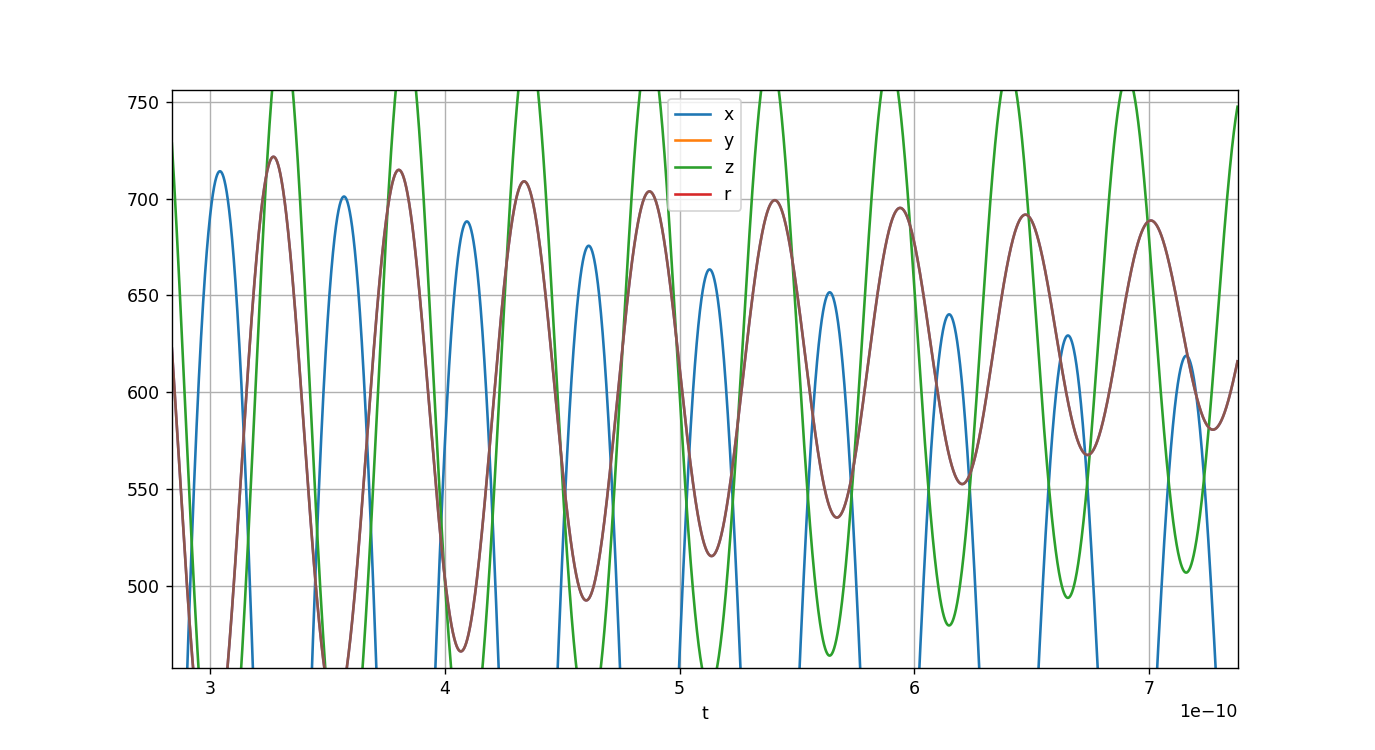

In [20]:
%matplotlib notebook

df.plot('t', figsize = (11, 6))
plt.grid(True)

In [22]:
from scipy.optimize import curve_fit

def func(x, fi0, f, tau1, tau2, A1, A2, C):
    return A1*np.exp(-x/tau1)*np.cos(2*np.pi*f*x + fi0) + C + A2*np.exp(-x/tau2)

par, ss = curve_fit(func, df.t, df.z, p0=[0, 18e9, 3e-9,1e-9, 200, 300, 600], maxfev=10000)
print(par)
print("f={} GHz".format(par[1]*1e-9))
plt.plot(df.t, func(df.t, par[0], par[1], par[2], par[3], par[4], par[5], par[6]))

[-7.57781287e-01  1.87192167e+10  3.84186725e-10  3.76178543e-10
  3.53951933e+02 -2.31407335e+02  6.67455858e+02]
f=18.7192167024518 GHz


<IPython.core.display.Javascript object>


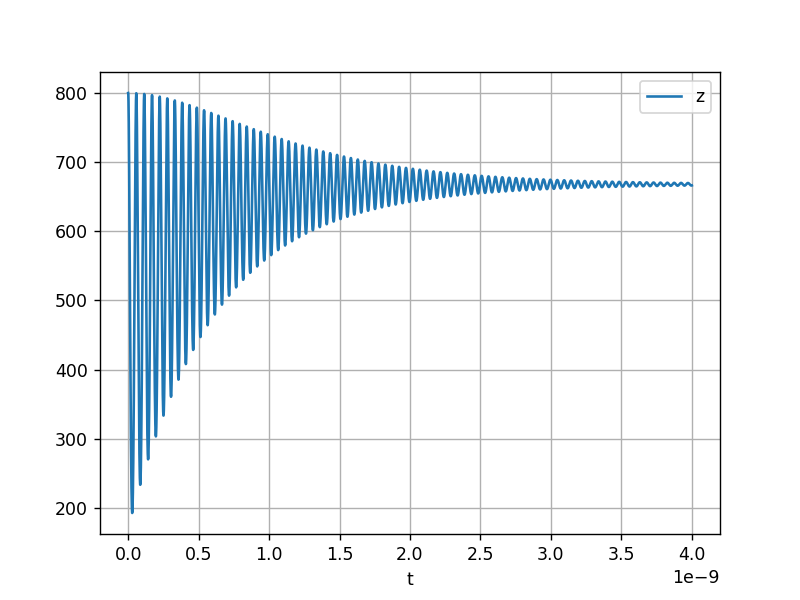

In [14]:
df.plot(x='t', y='z')
plt.grid(True)

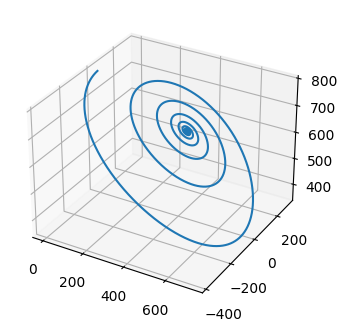

In [11]:
#%matplotlib inline
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])

freq: 19.249807500000006
delta: 0.2499975000000001


<IPython.core.display.Javascript object>


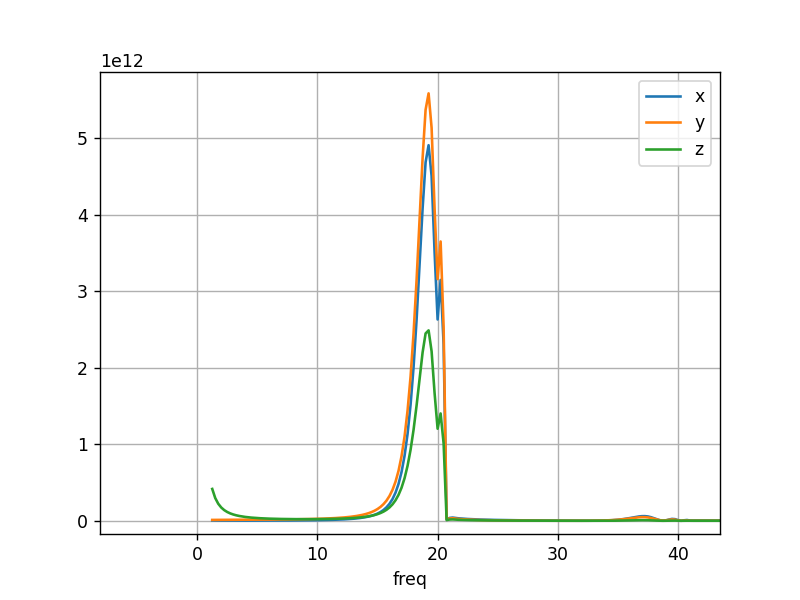

<IPython.core.display.Javascript object>


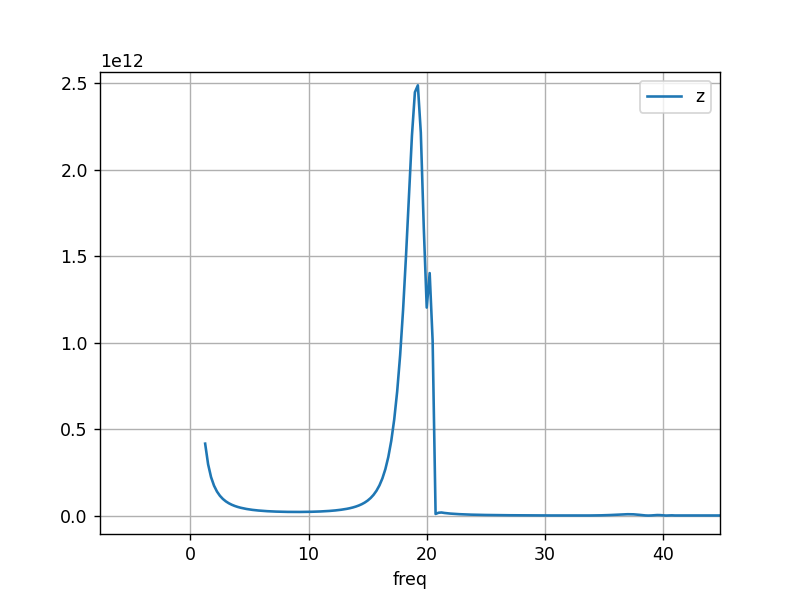

,freq,x,y,z
0,1.249988,4.115699e+09,1.116688e+10,4.158926e+11
1,1.499985,3.156024e+09,1.136043e+10,2.965391e+11
2,1.749983,2.577769e+09,1.151120e+10,2.222080e+11
3,1.999980,2.212447e+09,1.164212e+10,1.730390e+11
4,2.249978,1.975191e+09,1.176524e+10,1.389248e+11
...,...,...,...,...
990,248.747513,5.099836e+07,4.348270e+05,4.719259e+06
991,248.997510,5.089436e+07,4.330648e+05,4.709496e+06
992,249.247508,5.079068e+07,4.313116e+05,4.699764e+06
993,249.497505,5.068731e+07,4.295672e+05,4.690062e+06


In [13]:
%matplotlib notebook
freq_df = pd.DataFrame(columns=['freq','x','y','z'])

DC_offset = 5

freq_df['freq'] = np.fft.fftfreq(len(df.t), df.t[1]-df.t[0])[DC_offset:1000] * 1e-9

column_names = ['x','y','z']
for name in column_names:
    freq_df[name] = np.abs(np.fft.fft(df[name]))[DC_offset:1000]**2


print("freq: {}".format(freq_df['freq'][freq_df.z.argmax()]))
print("delta: {}".format(freq_df.freq[1]-freq_df.freq[0]))
freq_df.plot(x='freq', y=['x', 'y', 'z'])
plt.grid(True)
freq_df.plot(x='freq', y=['z'])
plt.grid(True)
freq_df

# legacy code

In [ ]:
def LLG(Heff, M, film):
    Ms = np.linalg.norm(M)
    
    first = np.cross(M, Heff)
    second = (film.alpha/Ms)*np.cross(M, np.cross(M, Heff))
    
    return -(film.gamma/(1+film.alpha**2))*(first + second)

In [ ]:
def StonerWohlfarth_Heff(M, Hkeff):
    M_abs, M_tet, M_phi = cart2pol(M)
    
    r = 0.5*Hkeff*(np.cos(M_tet)**2)
    tet = -0.5*Hkeff*np.sin(2.0*M_tet)
    
    return r*r_ort(M_tet, M_phi) + tet*tet_ort(M_tet, M_phi)

In [6]:
S = CoordSys3D('S')

Hkeff = symbols("Hkeff")
Mx, My, Mz = symbols("Mx My Mz")
M = Mx*S.i + My*S.j + Mz*S.k

Esh = -0.5*(Hkeff/M.magnitude())*((M.dot(S.k))**2)
print(Esh)
print()

Heff = [-Esh.diff(Mx), -Esh.diff(My), -Esh.diff(Mz)]
for i in range(3):
    print(simplify(Heff[i]))

-0.5*Hkeff*Mz**2/sqrt(Mx**2 + My**2 + Mz**2)

-0.5*Hkeff*Mx*Mz**2/(Mx**2 + My**2 + Mz**2)**(3/2)
-0.5*Hkeff*My*Mz**2/(Mx**2 + My**2 + Mz**2)**(3/2)
Hkeff*Mz*(1.0*Mx**2 + 1.0*My**2 + 0.5*Mz**2)/(Mx**2 + My**2 + Mz**2)**(3/2)


<IPython.core.display.Javascript object>


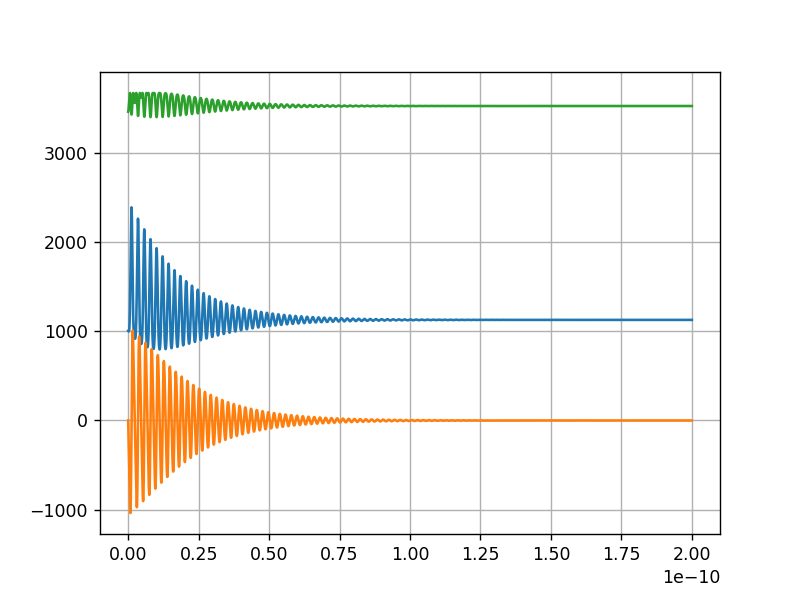

In [18]:
%matplotlib notebook

heff = [];
for i in range(len(sol.t)):
    heff.append(Heff_function(sol.y.T[i], film))

heff = np.array(heff).T

#ax.plot(heff[0], heff[1], heff[2])
plt.grid(True)
plt.plot(sol.t, heff[0])
plt.plot(sol.t, heff[1])
plt.plot(sol.t, heff[2])

<IPython.core.display.Javascript object>


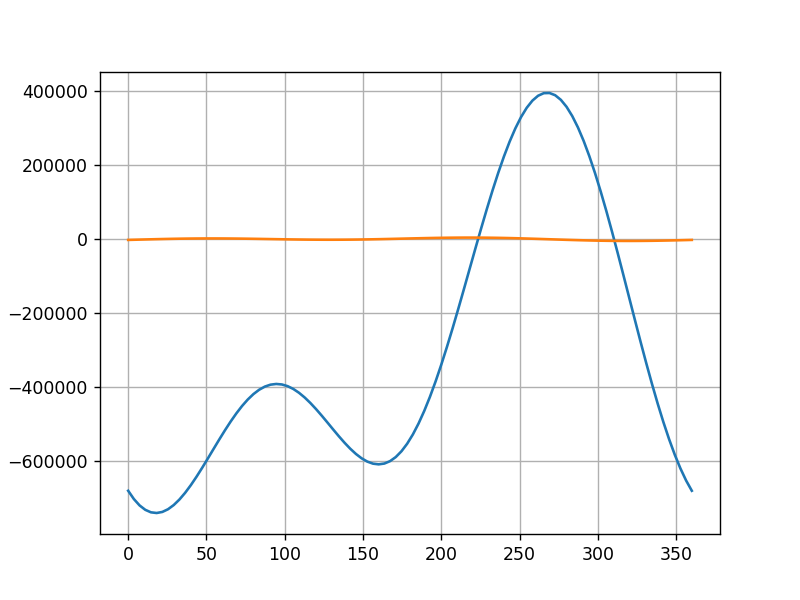

In [17]:
%matplotlib notebook
Hkeff_here = 6100.0
def F(Hext, M, tet):
    H_abs, H_tet, H_phi = cart2pol(Hext)
    M_abs, M_tet, M_phi = cart2pol(M)
    return -M_abs*H_abs*np.cos(H_tet - tet) - 0.5*M_abs*Hkeff_here*(np.cos(tet)**2)
    
def dF(Hext, M, tet):
    H_abs, H_tet, H_phi = cart2pol(Hext)
    M_abs, M_tet, M_phi = cart2pol(M)
    return 0.5*Hkeff_here*np.sin(2*tet) - H_abs*np.sin(H_tet - tet)
    
x = np.linspace(0,2*np.pi, 100)
y = []
y2 = []

Hext_here = np.array(pol2cart(2000.0, np.deg2rad(80.0), 0.0))
M0_here = np.array(pol2cart(200.0, np.deg2rad(80.0), 0.0))
for i in range(len(x)):
    y.append(F(Hext_here, M0_here, x[i]))
    y2.append(dF(Hext_here, M0_here, x[i]))

y = np.array(y)
plt.plot(np.rad2deg(x), y)
plt.plot(np.rad2deg(x), y2)
plt.grid()

theta